<a href="https://colab.research.google.com/github/Sharifjjemba/Sharifjjemba/blob/main/Studying_spatial_temporal_patterns_of_electricity_asset_vandalism0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-3-5677efe43740>:44: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  vandalism_gkma = gpd.sjoin(vandalism_gdf, gkma_polygon, op='within')


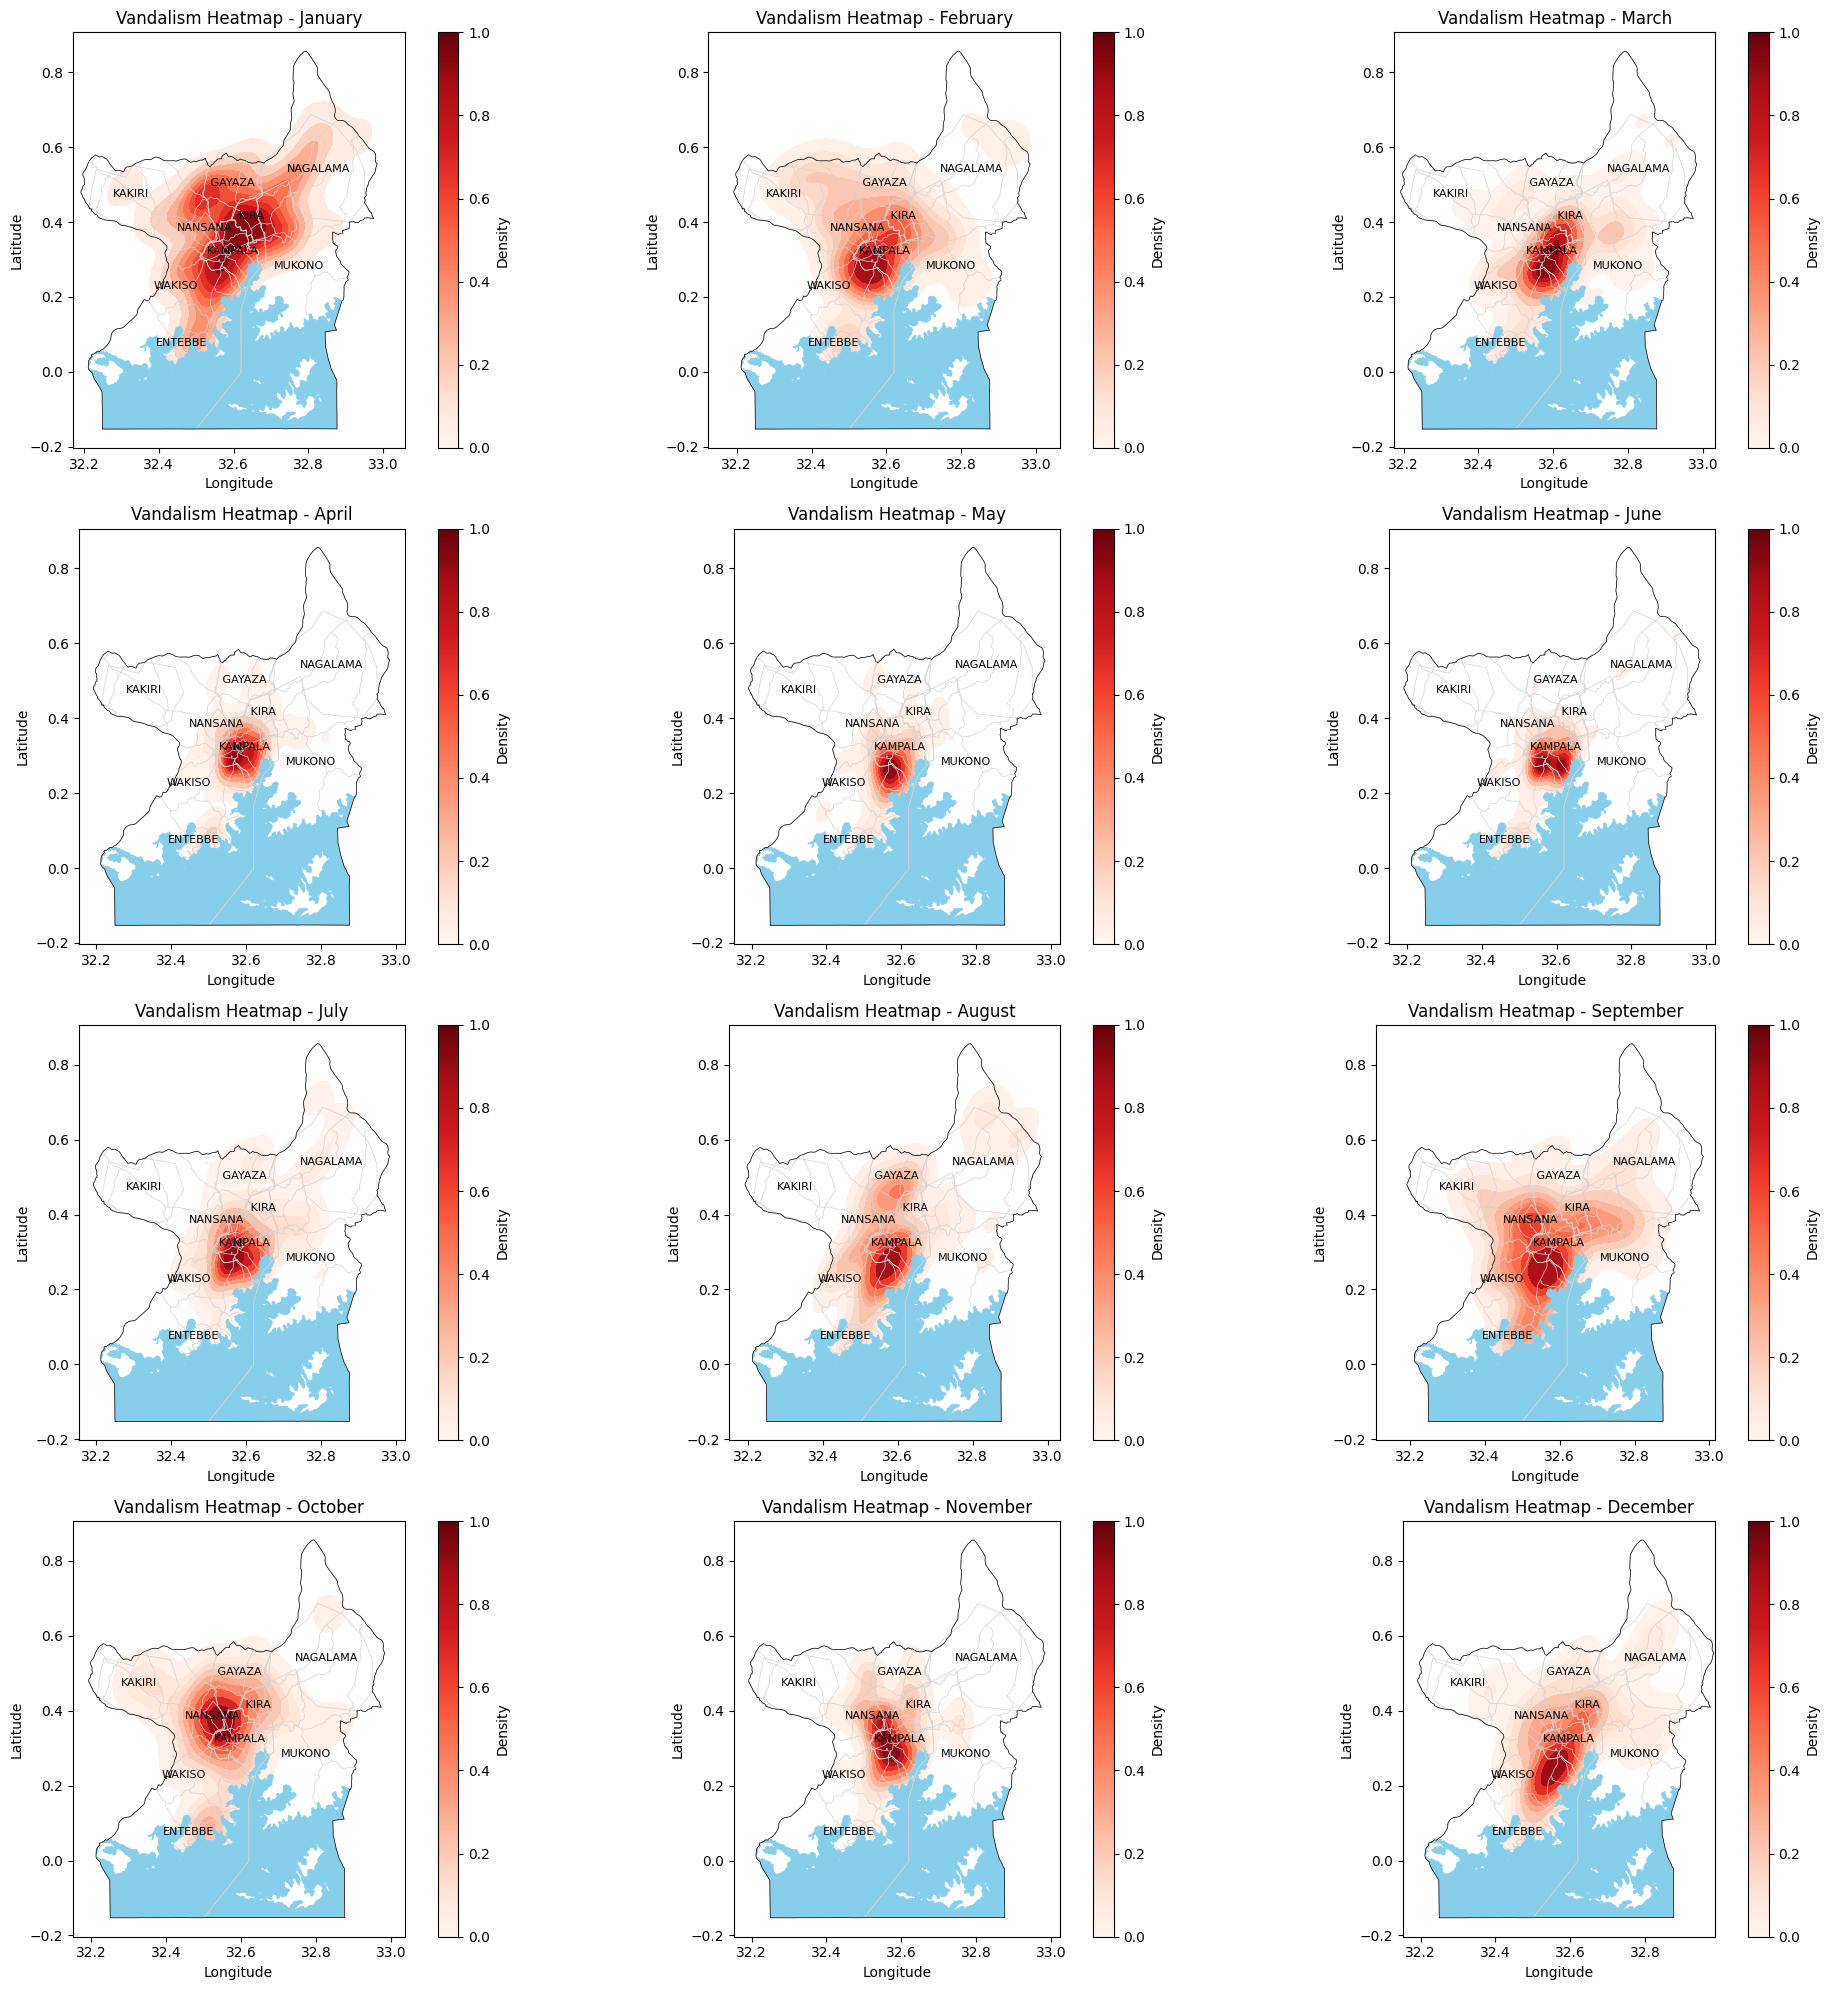

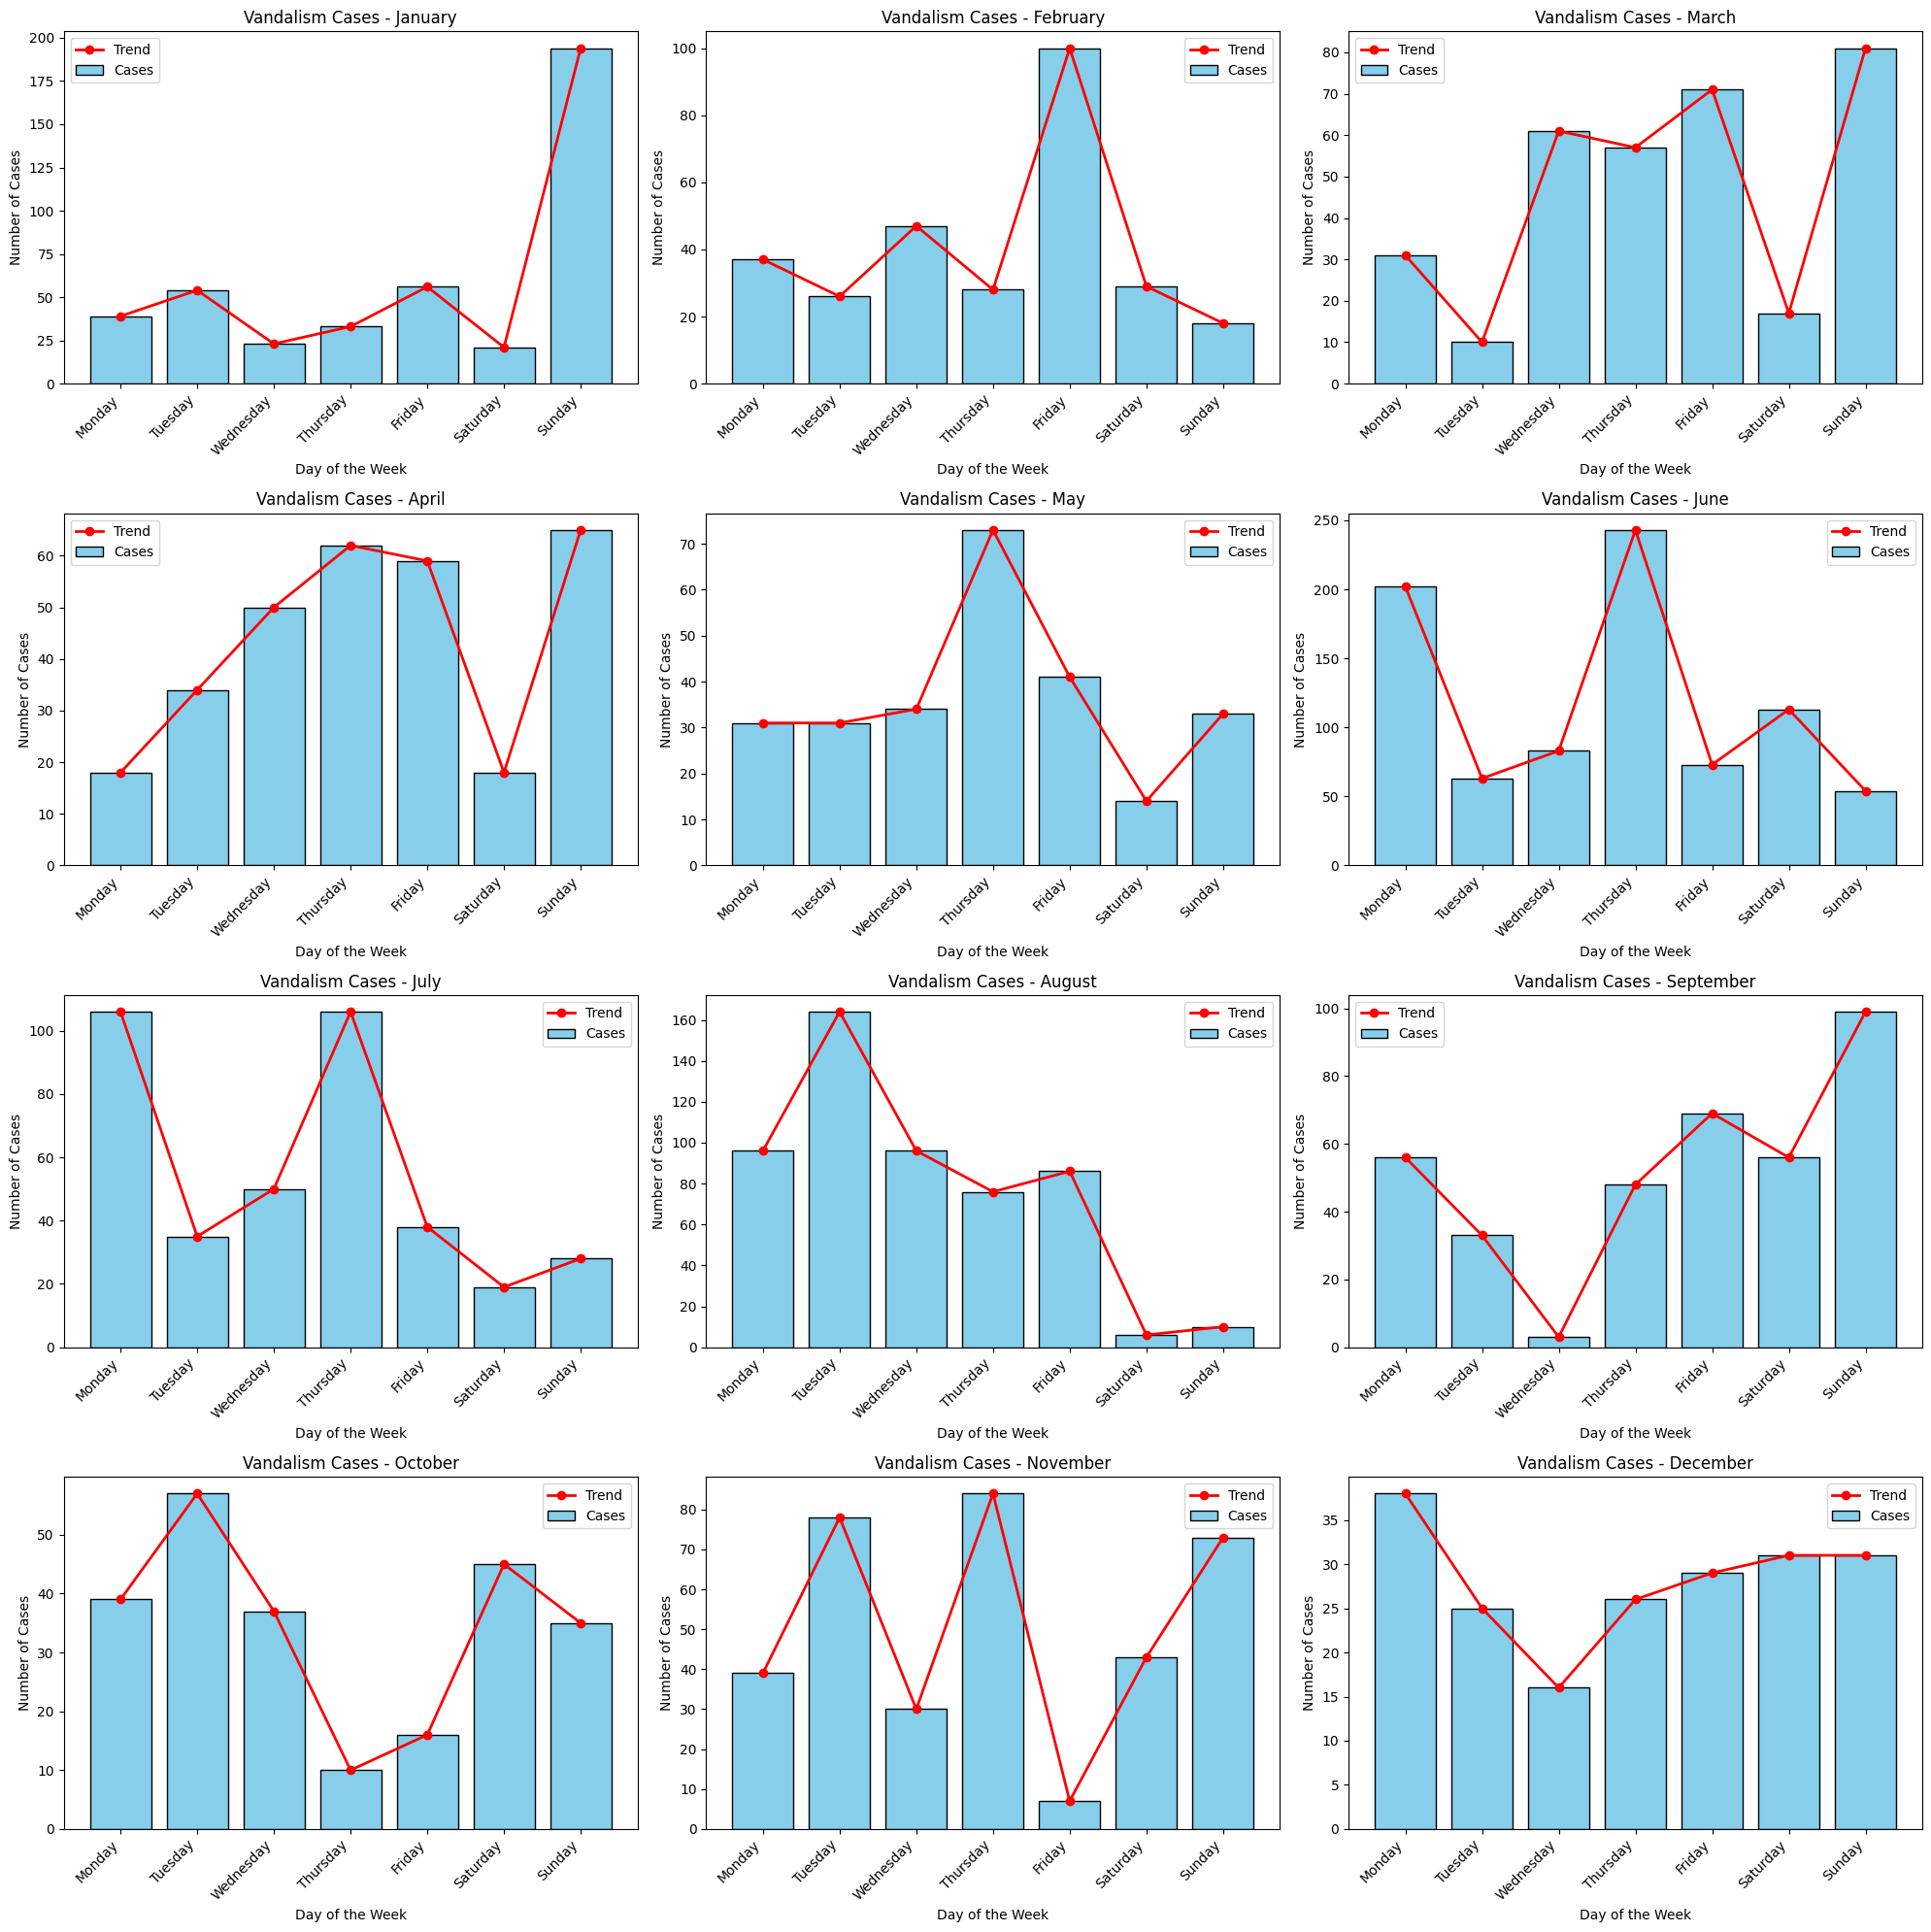

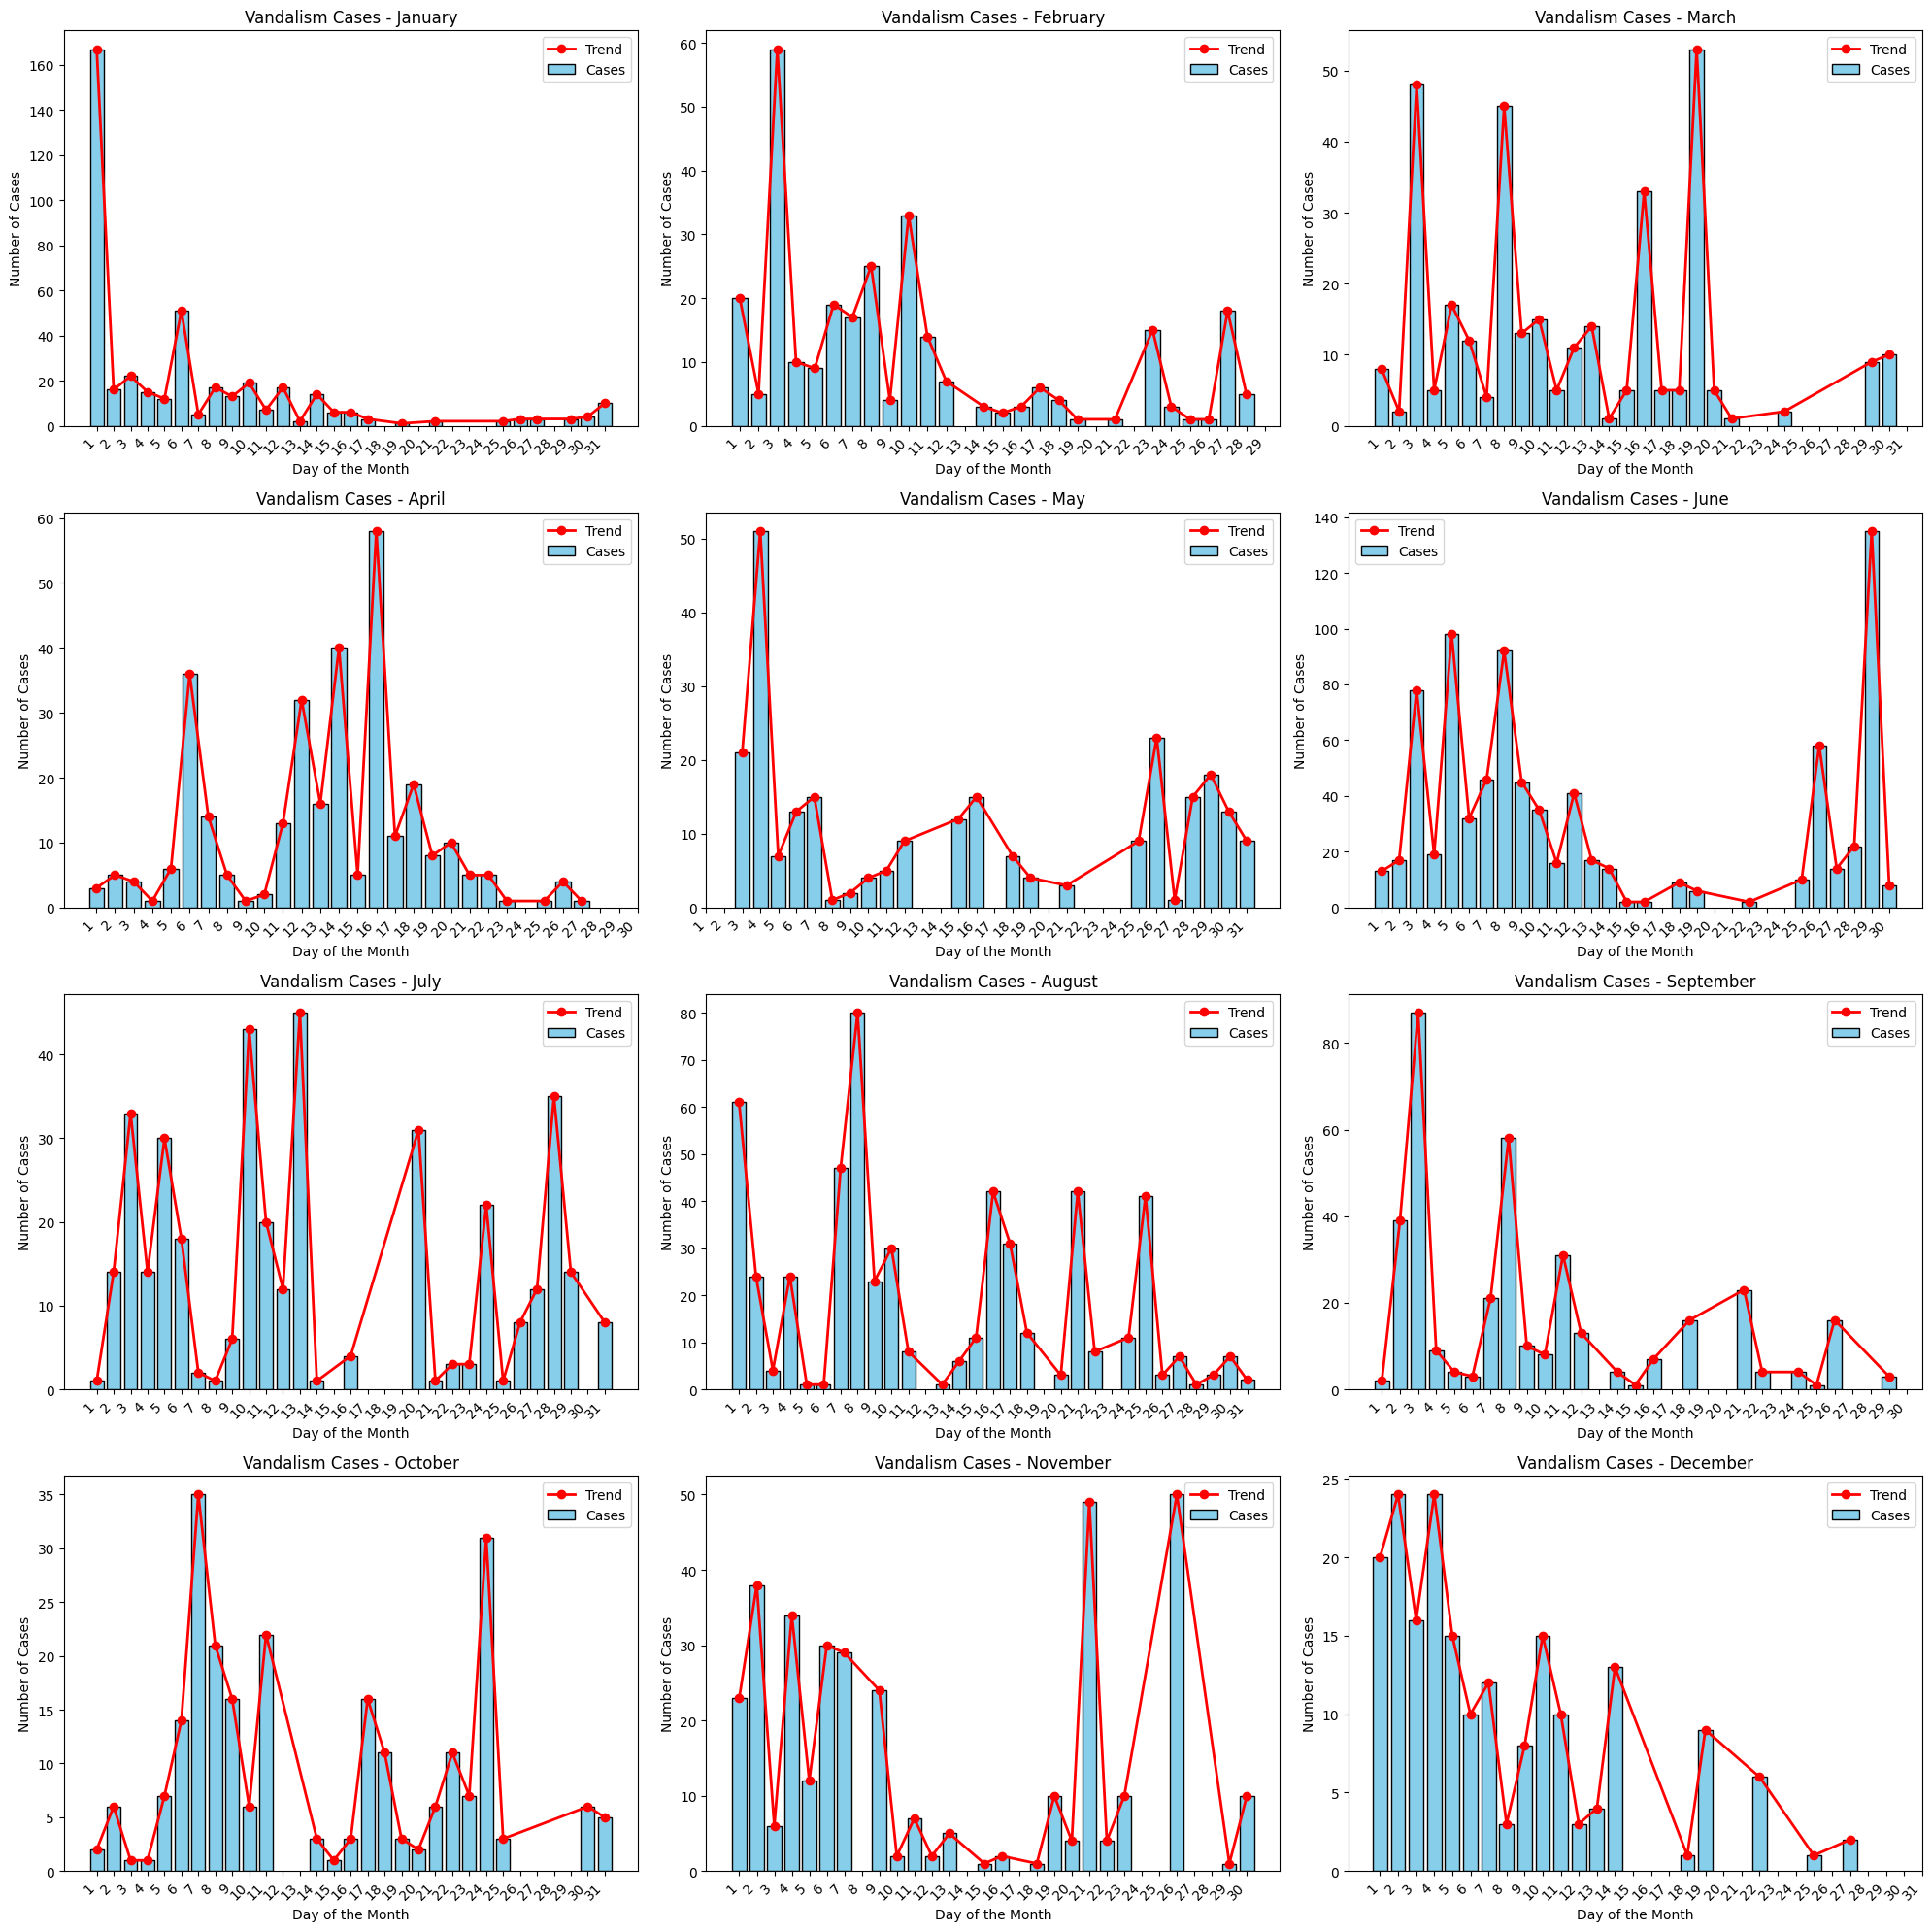

In [ ]:
#This project examines the spatial-temporal patterns of vandalism incidents
#The study area is Kampala metropolitan Area

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.colors as mcolors  # Import for custom color maps

# Read vandalism data from CSV file
vandalism_data = pd.read_csv('/content/drive/MyDrive/GKMA Vandalism data.csv')

# Convert auditdate column to datetime
vandalism_data['auditdate'] = pd.to_datetime(vandalism_data['auditdate'], format='%d/%m/%Y')

# Load GKMA polygon from JSON file
gkma_polygon = gpd.read_file('/content/drive/MyDrive/GKMA.geojson')

# Load Major roads data from GeoJSON file
Major_Roads_polyline = gpd.read_file('/content/drive/MyDrive/GKMA Major roads.json')

# Load Lake Victoria polygon from GeoJSON file
lake_victoria_polygon = gpd.read_file('/content/drive/MyDrive/Lake victoria.json')

# Load district boundaries data from GeoJSON file
district_boundaries = gpd.read_file('/content/drive/MyDrive/Districts.json')

# Convert x, y columns to geometry points
vandalism_data['geometry'] = vandalism_data.apply(lambda row: Point(row['x'], row['y']), axis=1)

# Create a GeoDataFrame from vandalism data
vandalism_gdf = gpd.GeoDataFrame(vandalism_data, geometry='geometry')

# Spatial join to filter vandalism data within GKMA polygon
vandalism_gkma = gpd.sjoin(vandalism_gdf, gkma_polygon, op='within')

# Select features for Random Forest
features = ['auditdate', 'x', 'y']
X = vandalism_gkma[features]
y = vandalism_gkma['Asset']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert auditdate column to timestamp
X_train['auditdate'] = X_train['auditdate'].astype(int) // 10**9  # Convert to Unix timestamp (seconds since epoch)
X_test['auditdate'] = X_test['auditdate'].astype(int) // 10**9  # Convert to Unix timestamp (seconds since epoch)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Extract month from 'auditdate'
vandalism_data['month'] = vandalism_data['auditdate'].dt.month

# Define month names
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Set up figure and axis for subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for month, ax in zip(range(1, 13), axes.flatten()):
    # Filter data for the current month
    vandalism_month = vandalism_data[vandalism_data['month'] == month]

    # Create the heatmap
    kde = sns.kdeplot(data=vandalism_month, x='x', y='y', fill=True, cmap='Reds', ax=ax, levels=10, thresh=0.05)
    ax.set_title(f'Vandalism Heatmap - {month_names[month-1]}', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)

    # Plot only the outline of GKMA polygon
    gkma_polygon.boundary.plot(ax=ax, color='black', linewidth=0.5)

    # Plot Lake Victoria polygon with the same color for both facecolor and edgecolor
    lake_victoria_polygon.plot(ax=ax, facecolor='skyblue', edgecolor='skyblue', linewidth=0.5)

    # Plot GKMA major roads with a light grey color and a thin line
    Major_Roads_polyline.plot(ax=ax, color='lightgrey', linewidth=0.5)

    # Plot district boundaries with lighter color and thinner lines
    district_boundaries.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.5)

    # Plot district labels
    for idx, row in district_boundaries.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['2020'], fontsize=8, ha='center')

    # Add colorbar with red ramp
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Normalize color bar to density values
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm.set_array([])  # Only needed for the colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Density', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Extract day of the week from 'auditdate'
vandalism_data['day_of_week'] = vandalism_data['auditdate'].dt.dayofweek

# Define day names (Sunday to Saturday)
day_names = list(calendar.day_name)

# Create a figure for subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# Loop through each month
for month, ax in zip(range(1, 13), axes.flatten()):
    # Filter data for the current month
    vandalism_month = vandalism_data[vandalism_data['month'] == month]

    # Group by day of the week and count occurrences
    vandalism_by_day = vandalism_month['day_of_week'].value_counts().sort_index()

    # Plot the bar chart
    ax.bar(vandalism_by_day.index, vandalism_by_day.values, color='skyblue', edgecolor='black', label='Cases')

    # Plot the line graph in red
    ax.plot(vandalism_by_day.index, vandalism_by_day.values, color='red', marker='o', linestyle='-', linewidth=2, label='Trend')

    # Set x-axis with day names
    ax.set_xticks(range(7))
    ax.set_xticklabels(day_names, rotation=45, ha='right')

    # Set titles and labels
    ax.set_title(f'Vandalism Cases - {month_names[month-1]}', fontsize=12)
    ax.set_xlabel('Day of the Week', fontsize=10)
    ax.set_ylabel('Number of Cases', fontsize=10)

    # Add legend
    ax.legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()

#Incidents per day of the month

# Extract day of the month from 'auditdate'
vandalism_data['day_of_month'] = vandalism_data['auditdate'].dt.day

# Dictionary to store the number of days for each month
days_in_month = {
    1: 31, 2: 29, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
}

# Create a figure for subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# Loop through each month
for month, ax in zip(range(1, 13), axes.flatten()):
    # Filter data for the current month
    vandalism_month = vandalism_data[vandalism_data['month'] == month]

    # Group by day of the month and count occurrences
    vandalism_by_day = vandalism_month['day_of_month'].value_counts().sort_index()

    # Determine the number of days for the current month
    num_days = days_in_month[month]

    # Plot the bar chart
    ax.bar(vandalism_by_day.index, vandalism_by_day.values, color='skyblue', edgecolor='black', label='Cases')

    # Plot the line graph in red
    ax.plot(vandalism_by_day.index, vandalism_by_day.values, color='red', marker='o', linestyle='-', linewidth=2, label='Trend')

    # Set x-axis with days
    ax.set_xticks(range(1, num_days + 1))
    ax.set_xticklabels(range(1, num_days + 1), rotation=45, ha='right')

    # Set titles and labels
    ax.set_title(f'Vandalism Cases - {month_names[month-1]}', fontsize=12)
    ax.set_xlabel('Day of the Month', fontsize=10)
    ax.set_ylabel('Number of Cases', fontsize=10)

    # Add legend
    ax.legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [ ]:

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW  # Importing from correct submodule
from mgwr.utils import shift_colormap

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Columns with zero variance: []
Variance Inflation Factors:
                    feature       VIF
0        population_density  1.439761
1                   poverty  4.306012
2              night_lights  4.312335
3  proximity_to_major_roads  1.634240


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-6-04f6f5813ab5>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=zero_variance_cols, inplace=True)


Model type                                                         Gaussian
Number of observations:                                                4459
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             36.570
Log-likelihood:                                                    4382.220
AIC:                                                              -8754.440
AICc:                                                             -8752.421
BIC:                                                             -37388.965
R2:                                                                   0.003
Adj. R2:                                                              0.002

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

GWR results saved to /content/drive/MyDrive/gwr_results.geojson


<ipython-input-6-04f6f5813ab5>:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(districts.geometry.centroid.x, districts.geometry.centroid.y, districts['2020']):
<ipython-input-6-04f6f5813ab5>:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(districts.geometry.centroid.x, districts.geometry.centroid.y, districts['2020']):
<ipython-input-6-04f6f5813ab5>:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(districts.geometry.centroid.x, districts.geometry.centroid.y, districts['2020']):
<ipython-input-6

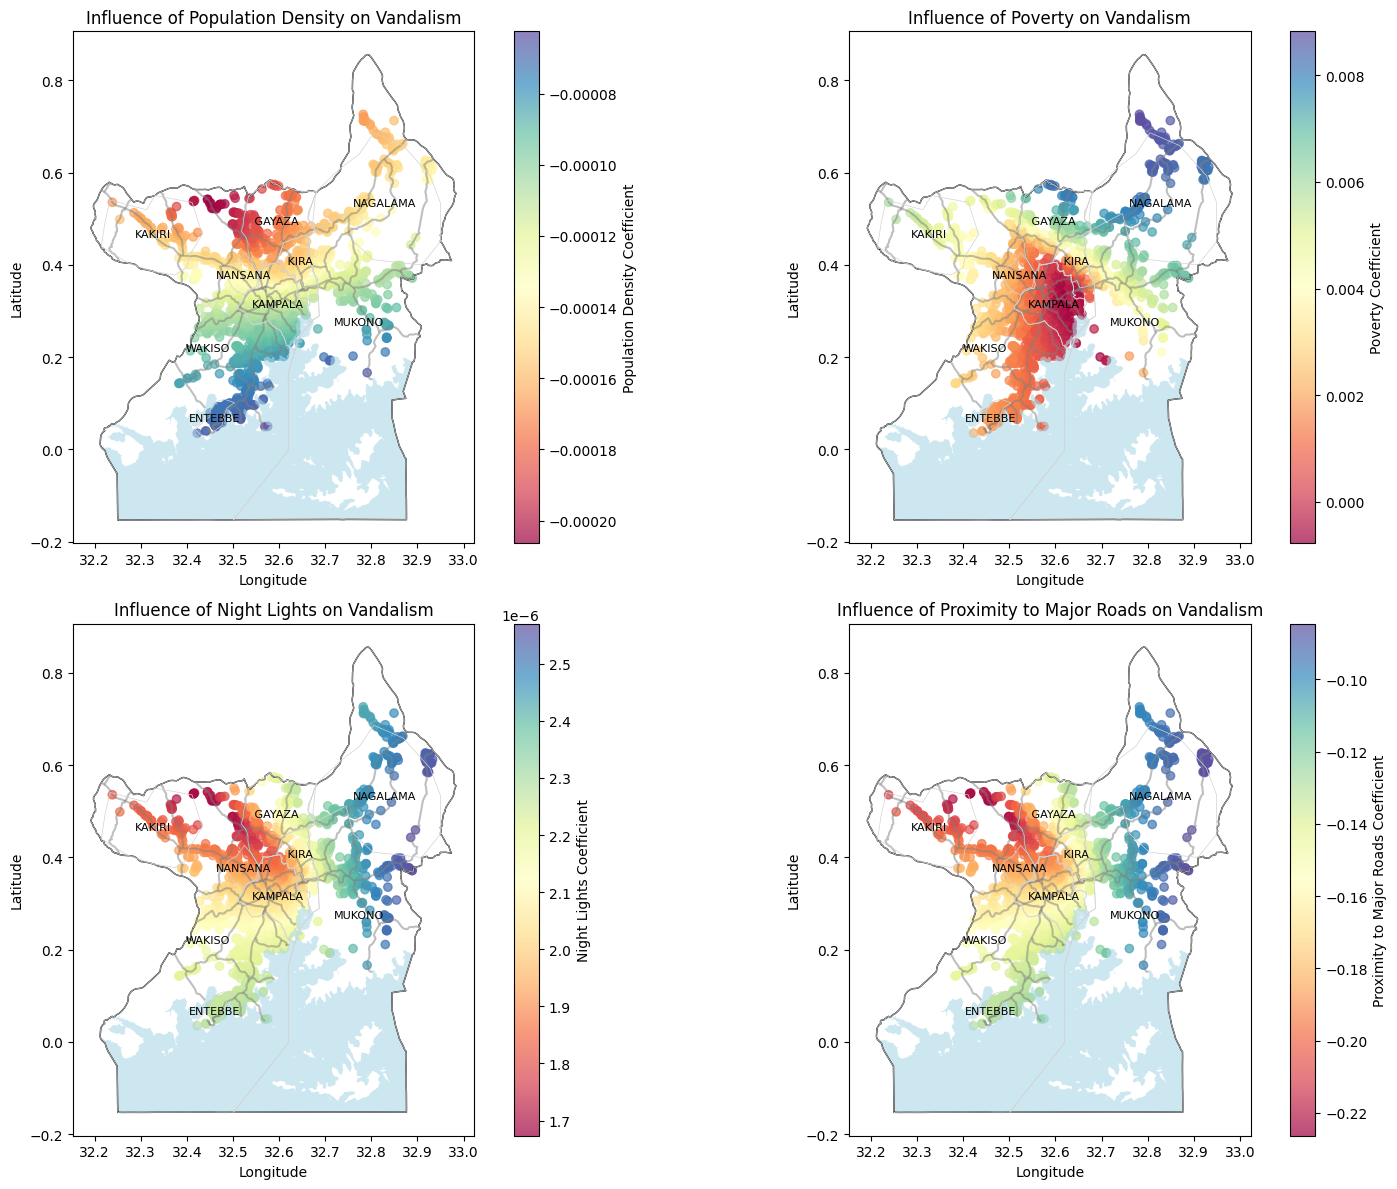

In [ ]:
#This code examines the spatially varrying relationships between patterns of vandalism and pull factors.
#It uses GKMA as the stdy area

#Import necessary libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Define file paths for each dataset and output
vandalism_csv_path = "/content/drive/MyDrive/GKMA Vandalism data.csv"
pop_density_tif_path = "/content/drive/MyDrive/population_density_2020_C.tif"
major_roads_geojson_path = "/content/drive/MyDrive/GKMA Major roads.json"
poverty_tif_path = "/content/drive/MyDrive/Poverty.tif"
night_lights_tif_path = "/content/drive/MyDrive/Nightlights.tif"
gkma_geojson_path = "/content/drive/MyDrive/GKMA.geojson"
districts_geojson_path = "/content/drive/MyDrive/Districts.json"
lake_victoria_geojson_path = "/content/drive/MyDrive/Lake victoria.json"
output_geojson_path = "/content/drive/MyDrive/gwr_results.geojson"

# Load CSV data for vandalism
vandalism_df = pd.read_csv(vandalism_csv_path, parse_dates=['auditdate'], dayfirst=True)
vandalism_df['vandalism_counts'] = 1
vandalism_agg = vandalism_df.groupby(['x', 'y']).agg({'vandalism_counts': 'sum'}).reset_index()
gdf_vandalism = gpd.GeoDataFrame(vandalism_agg, geometry=gpd.points_from_xy(vandalism_agg.x, vandalism_agg.y))
gdf_vandalism.crs = 'EPSG:4326'

# Load GKMA polygon
gkma_polygon = gpd.read_file(gkma_geojson_path)
gkma_polygon = gkma_polygon.to_crs(gdf_vandalism.crs)
gdf_vandalism_clipped = gpd.clip(gdf_vandalism, gkma_polygon)

# Load additional GeoJSONs
lake_victoria = gpd.read_file(lake_victoria_geojson_path)
major_roads = gpd.read_file(major_roads_geojson_path)
districts = gpd.read_file(districts_geojson_path)

# Function to extract values from a raster at given points
def extract_raster_values(raster_path, gdf_points):
    with rasterio.open(raster_path) as src:
        values = []
        for point in gdf_points.geometry:
            try:
                row, col = src.index(point.x, point.y)
                value = src.read(1)[row, col]
                if np.isnan(value):
                    value = 0
                values.append(value)
            except IndexError:
                values.append(0)
        return values

# Extract population density from GeoTIFF
gdf_vandalism_clipped['population_density'] = extract_raster_values(pop_density_tif_path, gdf_vandalism_clipped)

# Extract values for poverty and night lights
gdf_vandalism_clipped['poverty'] = extract_raster_values(poverty_tif_path, gdf_vandalism_clipped)
gdf_vandalism_clipped['night_lights'] = extract_raster_values(night_lights_tif_path, gdf_vandalism_clipped)

# Calculate proximity to major roads
def calculate_proximity(points_gdf, lines_gdf):
    tree = cKDTree(np.array([(x, y) for x, y in zip(lines_gdf.geometry.centroid.x, lines_gdf.geometry.centroid.y)]))
    distances, _ = tree.query([(x, y) for x, y in zip(points_gdf.geometry.x, points_gdf.geometry.y)])
    return distances

gdf_vandalism_clipped['proximity_to_major_roads'] = calculate_proximity(gdf_vandalism_clipped, major_roads)

# Function to check for zero variance predictors and drop them
def check_and_drop_zero_variance(df):
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    zero_variance_cols = [col for col in numerical_columns if df[col].var() == 0]
    print(f"Columns with zero variance: {zero_variance_cols}")
    df.drop(columns=zero_variance_cols, inplace=True)

# Check and drop zero variance predictors
check_and_drop_zero_variance(gdf_vandalism_clipped)

# Function to calculate Variance Inflation Factor (VIF) for multicollinearity analysis
def calculate_vif(df, features):
    scaler = StandardScaler()
    df_standardized = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(df_standardized.values, i) for i in range(len(features))]
    return vif_data

# List of features to check for multicollinearity
features = ['population_density', 'poverty', 'night_lights', 'proximity_to_major_roads']

# Calculate VIF for each feature
vif_df = calculate_vif(gdf_vandalism_clipped, features)
print("Variance Inflation Factors:")
print(vif_df)

# Prepare data for GWR if VIF is within acceptable range
if (vif_df['VIF'] > 10).any():
    print("Warning: High multicollinearity detected. Consider removing or combining predictors.")
else:
    coords = np.array(list(zip(gdf_vandalism_clipped.geometry.x, gdf_vandalism_clipped.geometry.y)))
    X = gdf_vandalism_clipped[features].values
    y = gdf_vandalism_clipped['vandalism_counts'].values.reshape(-1, 1)

    # Check if X and y are valid
    if X.size == 0 or y.size == 0:
        print("No valid samples available for GWR analysis.")
    else:
        # Select bandwidth for GWR using training data
        selector = Sel_BW(coords, y, X)
        bandwidth = selector.search()

        # Fit GWR model using training data
        gwr_model = GWR(coords, y, X, bw=bandwidth).fit()

        # Print GWR results
        print(gwr_model.summary())

        # Print shapes and parameters for debugging
        print(f"Shape of params: {gwr_model.params.shape}")
        print("Parameters:", gwr_model.params)

        # Check how many predictors were used
        num_predictors = gwr_model.params.shape[1] - 1  # Subtract 1 for the intercept

        # Add GWR coefficients to GeoDataFrame
        gdf_vandalism_clipped['gwr_intercept'] = gwr_model.params[:, 0]

        for i, factor in enumerate(['population_density', 'poverty', 'night_lights', 'proximity_to_major_roads']):
            if i < num_predictors:
                # Use the coefficients directly without amplification
                gdf_vandalism_clipped[f'gwr_coef_{factor}'] = gwr_model.params[:, i+1]
            else:
                print(f"Warning: Predictor {factor} was not included in the model.")

        # Save the results to a GeoJSON file
        gdf_vandalism_clipped.to_file(output_geojson_path, driver='GeoJSON')
        print(f"GWR results saved to {output_geojson_path}")

        # Plotting setup
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        axs = axs.flatten()

        # Feature names for plots
        feature_names = ['population_density', 'poverty', 'night_lights', 'proximity_to_major_roads']
        titles = ['Population Density', 'Poverty', 'Night Lights', 'Proximity to Major Roads']
        color_map = 'Spectral'  # Choosing a color ramp with better variance

        for i, feature in enumerate(feature_names):
            ax = axs[i]
            sc = ax.scatter(gdf_vandalism_clipped.geometry.x, gdf_vandalism_clipped.geometry.y,
                            c=gdf_vandalism_clipped[f'gwr_coef_{feature}'], cmap=color_map, alpha=0.7)
            ax.set_title(f'Influence of {titles[i]} on Vandalism')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            # Plot GKMA boundary
            gkma_polygon.boundary.plot(ax=ax, color='black', linewidth=1)

            # Plot Lake Victoria with water-like color
            lake_victoria.plot(ax=ax, color='#add8e6', alpha=0.6)  # Light blue color for water

            # Plot other GeoJSONs (Major Roads, Districts)
            major_roads.plot(ax=ax, color='gray', alpha=0.5)
            districts.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)

            # Label districts
            for x, y, label in zip(districts.geometry.centroid.x, districts.geometry.centroid.y, districts['2020']):
                ax.text(x, y, label, fontsize=8, color='black', ha='center', va='center')

            fig.colorbar(sc, ax=ax, label=f'{titles[i]} Coefficient')

        # Adjust layout
        plt.tight_layout()
        plt.show()


In [ ]:

!pip install mgwr

In [ ]:

!pip install --upgrade mgwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 748.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
pip install rasterio shapely fiona geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 21.3 MB/s eta 0:00:00
